In [75]:
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
from bayes_opt import BayesianOptimization
from lightgbm import plot_importance
import re
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load the appplication train and test data into pandas dataframes
app_train = pd.read_csv('home-credit-default-risk/application_train.csv')
app_test = pd.read_csv('home-credit-default-risk/application_test.csv')

app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


### Pre-processing application data

In [3]:
# Remove those rows where code_gender = 'XNA'
app_train.drop(app_train[app_train['CODE_GENDER'] == 'XNA'].index, inplace=True)
app_test.drop(app_test[app_test['CODE_GENDER'] == 'XNA'].index, inplace=True)

# Reset the index
app_train.reset_index(inplace=True)
app_test.reset_index(inplace=True)

# Drop the index column
app_train.drop('index', axis=1, inplace=True)
app_test.drop('index', axis=1, inplace=True)

In [4]:
# Replace 'DAYS_EMPLOYED = 365243' with NaN
app_train['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
app_test['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)

In [5]:
# Seperate ID and Target columns from train; Delete those two columns from app_train dataset
train_id_target = app_train[['SK_ID_CURR', 'TARGET']]
app_train.drop(['SK_ID_CURR', 'TARGET'], axis=1, inplace=True)

# Seperate ID column from test; Delete this column from app_test dataset
test_id = app_test['SK_ID_CURR']
app_test.drop('SK_ID_CURR', axis=1, inplace=True)

app_train.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# Drop those columns with more than 50% missing values

missing_percent = app_train.isnull().sum() * 100 / len(app_train)
# missing_percent[missing_percent > 50]
# There are many columns with more than 50% missing values
# But only OWN_CAR_AGE, EXT_SOURCE_1, FONDKAPREMONT_MODE, HOUSETYPE_MODE, WALLSMATERIAL_MODE are removed as all other
# features give information about the client's house

app_train.drop(['OWN_CAR_AGE', 'EXT_SOURCE_1', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE'], axis=1, 
               inplace=True)
app_test.drop(['OWN_CAR_AGE', 'EXT_SOURCE_1', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE'], axis=1, 
               inplace=True)

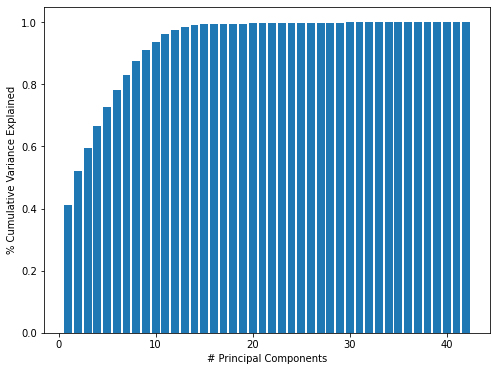

In [7]:
# HOUSING PCA

# app_train.columns[40:82]
# app_test.columns[40:82]
housing = app_train.iloc[:, 40:82]
housing = housing.fillna(housing.median())
housing_scaler = StandardScaler()
housing = pd.DataFrame(housing_scaler.fit_transform(housing), columns = housing.columns)
pca_1 = PCA(n_components=42)
housing_pca = pca_1.fit_transform(housing)

house_exp_var = []
var_exp = 0
for i in pca_1.explained_variance_ratio_:
    var_exp += i
    house_exp_var.append(var_exp)


# Plot cumulative explained variance for all PCs

fig, ax = plt.subplots(figsize=(8,6))
ax.bar(range(1,43), house_exp_var)
ax.set_xlabel('# Principal Components')
ax.set_ylabel('% Cumulative Variance Explained')
plt.show()

In [8]:
# From the above plot, we can see that the first 10 principal components of housing columns explain more than 90% 
# of the variance
house_cols = ['HOUSING_1', 'HOUSING_2', 'HOUSING_3', 'HOUSING_4', 'HOUSING_5', 'HOUSING_6', 'HOUSING_7', 'HOUSING_8',
             'HOUSING_9', 'HOUSING_10']
housing = pd.DataFrame(housing_pca[:,:10], columns = house_cols)


# Replicate the housing PCA on test data as well
housing_test = app_test.iloc[:, 40:82]
housing_test = housing_test.fillna(housing_test.median())
housing_scaler = StandardScaler()
housing_test = pd.DataFrame(housing_scaler.fit_transform(housing_test), columns = housing_test.columns)
pca_1 = PCA(n_components=42)
housing_pca = pca_1.fit_transform(housing_test)
housing_test = pd.DataFrame(housing_pca[:,:10], columns = house_cols)

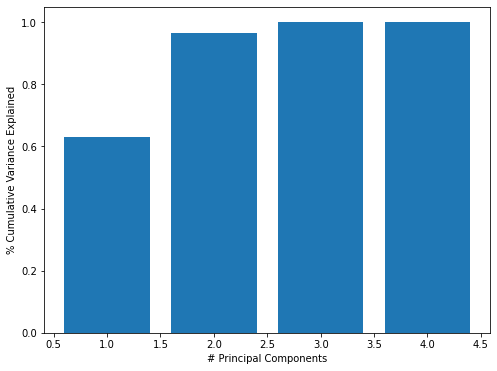

In [9]:
# SOCIAL CIRCLE PCA

soc_circle = app_train.iloc[:, 84:88]
soc_circle = soc_circle.fillna(soc_circle.median())
soc_circle_scaler = StandardScaler()
soc_circle = pd.DataFrame(soc_circle_scaler.fit_transform(soc_circle), columns = soc_circle.columns)
pca_2 = PCA(n_components=4)
soc_circle_pca = pca_2.fit_transform(soc_circle)

soc_circle_exp_var = []
var_exp = 0
for i in pca_2.explained_variance_ratio_:
    var_exp += i
    soc_circle_exp_var.append(var_exp)


# Plot cumulative explained variance for all PCs

fig, ax = plt.subplots(figsize=(8,6))
ax.bar(range(1,5), soc_circle_exp_var)
ax.set_xlabel('# Principal Components')
ax.set_ylabel('% Cumulative Variance Explained')
plt.show()

In [10]:
# From the above plot, we can see that the first 2 principal components of social circle columns explain more than 90% 
# of the variance
soc_circle_cols = ['SOCIAL_CIRCLE_1', 'SOCIAL_CIRCLE_2']
soc_circle = pd.DataFrame(soc_circle_pca[:,:2], columns = soc_circle_cols)


# Replicate the housing PCA on test data as well
soc_circle_test = app_test.iloc[:, 84:88]
soc_circle_test = soc_circle_test.fillna(soc_circle_test.median())
soc_circle_scaler = StandardScaler()
soc_circle_test = pd.DataFrame(soc_circle_scaler.fit_transform(soc_circle_test), columns = soc_circle_test.columns)
pca_2 = PCA(n_components=4)
soc_circle_pca = pca_2.fit_transform(soc_circle_test)
soc_circle_test = pd.DataFrame(soc_circle_pca[:,:2], columns = soc_circle_cols)

In [11]:
# Remove these housing columns from train and test data
app_train.drop(app_train.columns[40:82], axis=1, inplace=True)
app_test.drop(app_test.columns[40:82], axis=1, inplace=True)


# Remove these social circle columns from train and test data
app_train.drop(app_train.columns[84:88], axis=1, inplace=True)
app_test.drop(app_test.columns[84:88], axis=1, inplace=True)

In [12]:
# Define columns that are binary-label string, multi-label string and continuous float
binary_cols = app_train.columns[:4].tolist()
multi_cols = ['NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
             'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'EMERGENCYSTATE_MODE']
num_cols = app_train.columns[4:9].tolist() + app_train.columns[14:19].tolist() + app_train.columns[26:29].tolist() + ['HOUR_APPR_PROCESS_START', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'TOTALAREA_MODE', 'DAYS_LAST_PHONE_CHANGE'] + app_train.columns[-6:].tolist()

In [13]:
# Impute missing values of binary-label and multi-label columns with mode
for col in binary_cols + multi_cols:
    app_train[col].fillna(app_train[col].mode(), inplace=True)
    app_test[col].fillna(app_test[col].mode(), inplace=True)

# Impute missing values of numeric columns with median
for col in num_cols:
    app_train[col].fillna(app_train[col].median(), inplace=True)
    app_test[col].fillna(app_test[col].median(), inplace=True)

In [14]:
# Concat the new housing and social circle PCA components to the train and test data
app_train = pd.concat([app_train, housing, soc_circle], axis=1)
app_test = pd.concat([app_test, housing_test, soc_circle_test], axis=1)

In [15]:
# Combine train and test for the sake of encoding
app_train['TEST_FLAG'] = 0
app_test['TEST_FLAG'] = 1

app_train = pd.concat([app_train, app_test])

In [16]:
# Label Encoding for binary-label categorical features
app_train[binary_cols] = app_train[binary_cols].apply(LabelEncoder().fit_transform)
# app_test[binary_cols] = app_test[binary_cols].apply(LabelEncoder().fit_transform)

# One-hot encoding for multi-label categorical features
for col in multi_cols:
    one_hot_train = pd.get_dummies(app_train[col], prefix=col)
#     one_hot_test = pd.get_dummies(app_test[col], prefix=col)
    
    app_train.drop(col, axis=1, inplace=True)
#     app_test.drop(col, axis=1, inplace=True)
    
    app_train = pd.concat([app_train, one_hot_train], axis=1)
#     app_test = pd.concat([app_test, one_hot_test], axis=1)

In [17]:
# Seperate the train and test datasets for further processing

app_test = app_train[app_train['TEST_FLAG'] == 1]
app_train = app_train[app_train['TEST_FLAG'] == 0]

app_train.drop('TEST_FLAG', axis=1, inplace=True)
app_test.drop('TEST_FLAG', axis=1, inplace=True)

In [18]:
# Get the document and amount_required_credit _bureau column names
docs = [_f for _f in app_train.columns if 'FLAG_DOC' in _f]
amt_req = [_f for _f in app_train.columns if 'AMT_REQ_CREDIT_BUREAU' in _f]

# More Features
features = pd.DataFrame()
features_test = pd.DataFrame()

features['CREDIT_ANNUITY_RATIO'] = app_train['AMT_CREDIT'] / app_train['AMT_ANNUITY']
features_test['CREDIT_ANNUITY_RATIO'] = app_test['AMT_CREDIT'] / app_test['AMT_ANNUITY']

features['CREDIT_GOODS_RATIO'] = app_train['AMT_CREDIT'] / app_train['AMT_GOODS_PRICE']
features_test['CREDIT_GOODS_RATIO'] = app_test['AMT_CREDIT'] / app_test['AMT_GOODS_PRICE']

features['BIRTH_EMPLOYED_RATIO'] = app_train['DAYS_EMPLOYED'] / app_train['DAYS_BIRTH']
features_test['BIRTH_EMPLOYED_RATIO'] = app_test['DAYS_EMPLOYED'] / app_test['DAYS_BIRTH']

features['DOC_IND_AVG'] = app_train[docs].mean(axis=1)
features_test['DOC_IND_AVG'] = app_test[docs].mean(axis=1)
features['DOC_IND_STD'] = app_train[docs].std(axis=1)
features_test['DOC_IND_STD'] = app_test[docs].std(axis=1)
features['DOC_IND_SUM'] = app_train[docs].sum(axis=1)
features_test['DOC_IND_SUM'] = app_test[docs].sum(axis=1)

features['AMT_REQ_CREDIT_BUREAU_TOTAL'] = app_train[amt_req].sum(axis=1)
features_test['AMT_REQ_CREDIT_BUREAU_TOTAL'] = app_test[amt_req].sum(axis=1)

features['CHILDREN_RATIO'] = app_train['CNT_CHILDREN'] / app_train['CNT_FAM_MEMBERS']
features_test['CHILDREN_RATIO'] = app_test['CNT_CHILDREN'] / app_test['CNT_FAM_MEMBERS']

features['INCOME_PER_CHLD'] = app_train['AMT_INCOME_TOTAL'] / (1 + app_train['CNT_CHILDREN'])
features_test['INCOME_PER_CHLD'] = app_test['AMT_INCOME_TOTAL'] / (1 + app_test['CNT_CHILDREN'])

features['ANNUITY_TO_INCOME_RATIO'] = app_train['AMT_ANNUITY'] / (1 + app_train['AMT_INCOME_TOTAL'])
features_test['ANNUITY_TO_INCOME_RATIO'] = app_test['AMT_ANNUITY'] / (1 + app_test['AMT_INCOME_TOTAL'])

features['EXT_SOURCES_PROD'] = app_train['EXT_SOURCE_2'] * app_train['EXT_SOURCE_3']
features_test['EXT_SOURCES_PROD'] = app_test['EXT_SOURCE_2'] * app_test['EXT_SOURCE_3']

features['EXT_SOURCES_MEAN'] = app_train[['EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
features_test['EXT_SOURCES_MEAN'] = app_test[['EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)

features['EXT_SOURCES_STD'] = app_train[['EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
features_test['EXT_SOURCES_STD'] = app_test[['EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)

features['PHONE_TO_BIRTH_RATIO'] = app_train['DAYS_LAST_PHONE_CHANGE'] / app_train['DAYS_BIRTH']
features_test['PHONE_TO_BIRTH_RATIO'] = app_test['DAYS_LAST_PHONE_CHANGE'] / app_test['DAYS_BIRTH']

features['PHONE_TO_EMPLOY_RATIO'] = app_train['DAYS_LAST_PHONE_CHANGE'] / (-1 + app_train['DAYS_EMPLOYED'])
features_test['PHONE_TO_EMPLOY_RATIO'] = app_test['DAYS_LAST_PHONE_CHANGE'] / (-1 + app_test['DAYS_EMPLOYED'])

features['CREDIT_TO_INCOME_RATIO'] = app_train['AMT_CREDIT'] / app_train['AMT_INCOME_TOTAL']
features_test['CREDIT_TO_INCOME_RATIO'] = app_test['AMT_CREDIT'] / app_test['AMT_INCOME_TOTAL']

# Reference 1 - https://www.kaggle.com/code/ogrellier/lighgbm-with-selected-features/script
# Reference 2 - https://www.kaggle.com/code/sz8416/eda-baseline-model-using-application/notebook

In [19]:
# Concat sk_id_curr, target, train/test and more features
app_train = pd.concat([train_id_target, app_train, features], axis=1)
app_test = pd.concat([test_id, app_test, features_test], axis=1)

### Pre-processing 'Bureau' Data

In [20]:
# above .data file is comma delimited
file_path = 'home-credit-default-risk/bureau.csv'
bru = pd.read_csv(file_path, delimiter=",")

References:
1) https://www.kaggle.com/code/shanth84/home-credit-bureau-data-feature-engineering
    

In [21]:
bru.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


Notes
- SK current is the current loan id
- For each current loan id there will be multiple current/previous loans with other organisation which is representeed by sk_id_bureau
- credit_active - active (loan still under progress) and closed means loan is over

Feature 1 - Number of Loans customer has (active and closed included)

In [22]:
fe = bru[['SK_ID_CURR', 'DAYS_CREDIT']].groupby(by = ['SK_ID_CURR'])['DAYS_CREDIT'].count().reset_index().rename(index=str, columns={'DAYS_CREDIT': 'BUREAU_LOAN_COUNT'})
#bru = bru.merge(grp, on = ['SK_ID_CURR'], how = 'left')
#print(bru.shape)

Feature 2 - Number of Loan types customer has

In [23]:
temp = bru[['SK_ID_CURR', 'CREDIT_TYPE']].groupby(by = ['SK_ID_CURR'])['CREDIT_TYPE'].nunique().reset_index().rename(index=str, columns={'CREDIT_TYPE': 'BUREAU_LOAN_TYPES'})
fe = fe.merge(temp, on = ['SK_ID_CURR'], how = 'left')
#print(B.shape)

Feature 3 - Number of active loans customer has

In [24]:
bru['CREDIT_ACTIVE_BINARY'] = bru['CREDIT_ACTIVE']

def f(x):
    if x == 'Closed':
        y = 0
    else:
        y = 1    
    return y

bru['CREDIT_ACTIVE_BINARY'] = bru.apply(lambda x: f(x.CREDIT_ACTIVE), axis = 1)

In [25]:
bru['CREDIT_ACTIVE_BINARY'] = bru.apply(lambda x: f(x.CREDIT_ACTIVE), axis = 1)
temp = bru[bru['CREDIT_ACTIVE_BINARY']== 1]
temp2 = temp[['SK_ID_CURR', 'DAYS_CREDIT']].groupby(by = ['SK_ID_CURR'])['DAYS_CREDIT'].count().reset_index().rename(index=str, columns={'DAYS_CREDIT': 'BUREAU_ACTIVE_LOAN_COUNT'})
fe = fe.merge(temp2, on = ['SK_ID_CURR'], how = 'left')

In [26]:
fe['BUREAU_ACTIVE_LOAN_COUNT'] = fe['BUREAU_ACTIVE_LOAN_COUNT'].fillna(0)

INTERPRETING CREDIT_DAYS_ENDDATE
Here I am finding the proportion of loans where the Credit Enddate is positive
What does High proportion of credit end date mean? - most of their bureau loans credit end date has been completed

In [27]:
bru['CREDIT_ENDDATE_BINARY'] = bru['DAYS_CREDIT_ENDDATE']

def f(x):
    if x<0:
        y = 0
    else:
        y = 1   
    return y

bru['CREDIT_ENDDATE_BINARY'] = bru.apply(lambda x: f(x.DAYS_CREDIT_ENDDATE), axis = 1)


temp = bru.groupby(by = ['SK_ID_CURR'])['CREDIT_ENDDATE_BINARY'].mean().reset_index().rename(index=str, columns={'CREDIT_ENDDATE_BINARY': 'CREDIT_ENDDATE_PERCENTAGE'})
fe = fe.merge(temp, on = ['SK_ID_CURR'], how = 'left')

Credit is the money you can borrow
Debt is the money u owe

In [28]:
bru['AMT_CREDIT_SUM_DEBT'] = bru['AMT_CREDIT_SUM_DEBT'].fillna(0)
bru['AMT_CREDIT_SUM'] = bru['AMT_CREDIT_SUM'].fillna(0)

grp1 = bru[['SK_ID_CURR', 'AMT_CREDIT_SUM_DEBT']].groupby(by = ['SK_ID_CURR'])['AMT_CREDIT_SUM_DEBT'].sum().reset_index().rename( index = str, columns = { 'AMT_CREDIT_SUM_DEBT': 'TOTAL_CUSTOMER_DEBT'})
grp2 = bru[['SK_ID_CURR', 'AMT_CREDIT_SUM']].groupby(by = ['SK_ID_CURR'])['AMT_CREDIT_SUM'].sum().reset_index().rename( index = str, columns = { 'AMT_CREDIT_SUM': 'TOTAL_CUSTOMER_CREDIT'})

grp3 = bru[['SK_ID_CURR', 'AMT_CREDIT_SUM_DEBT']].groupby(by = ['SK_ID_CURR'])['AMT_CREDIT_SUM_DEBT'].mean().reset_index().rename( index = str, columns = { 'AMT_CREDIT_SUM_DEBT': 'MEAN_CUSTOMER_DEBT'})
grp4 = bru[['SK_ID_CURR', 'AMT_CREDIT_SUM']].groupby(by = ['SK_ID_CURR'])['AMT_CREDIT_SUM'].mean().reset_index().rename( index = str, columns = { 'AMT_CREDIT_SUM': 'MEAN_CUSTOMER_CREDIT'})


grp5 = bru[['SK_ID_CURR', 'AMT_CREDIT_SUM_DEBT']].groupby(by = ['SK_ID_CURR'])['AMT_CREDIT_SUM_DEBT'].median().reset_index().rename( index = str, columns = { 'AMT_CREDIT_SUM_DEBT': 'MEDIAN_CUSTOMER_DEBT'})
grp6 = bru[['SK_ID_CURR', 'AMT_CREDIT_SUM']].groupby(by = ['SK_ID_CURR'])['AMT_CREDIT_SUM'].median().reset_index().rename( index = str, columns = { 'AMT_CREDIT_SUM': 'MEDIAN_CUSTOMER_CREDIT'})

fe = fe.merge(grp1, on = ['SK_ID_CURR'], how = 'left')
fe = fe.merge(grp2, on = ['SK_ID_CURR'], how = 'left')
fe = fe.merge(grp3, on = ['SK_ID_CURR'], how = 'left')
fe = fe.merge(grp4, on = ['SK_ID_CURR'], how = 'left')
fe = fe.merge(grp5, on = ['SK_ID_CURR'], how = 'left')
fe = fe.merge(grp6, on = ['SK_ID_CURR'], how = 'left')

#fe['DEBT_CREDIT_RATIO'] = fe['TOTAL_CUSTOMER_DEBT']/fe['TOTAL_CUSTOMER_CREDIT']

#fe.drop('TOTAL_CUSTOMER_DEBT', inplace=True, axis=1)
#fe.drop('TOTAL_CUSTOMER_CREDIT', inplace=True, axis=1)


Average number of loans prolonged
CNT_CREDIT_PROLONG - Number of days past due on CB credit at the time of application for related loan in our sample

In [29]:
bru['CNT_CREDIT_PROLONG'] = bru['CNT_CREDIT_PROLONG'].fillna(0)
grp = bru[['SK_ID_CURR', 'CNT_CREDIT_PROLONG']].groupby(by = ['SK_ID_CURR'])['CNT_CREDIT_PROLONG'].mean().reset_index().rename( index = str, columns = { 'CNT_CREDIT_PROLONG': 'MEAN_CREDITDAYS_PROLONGED'})
grp2 = bru[['SK_ID_CURR', 'CNT_CREDIT_PROLONG']].groupby(by = ['SK_ID_CURR'])['CNT_CREDIT_PROLONG'].median().reset_index().rename( index = str, columns = { 'CNT_CREDIT_PROLONG': 'MEDIAN_CREDITDAYS_PROLONGED'})

fe = fe.merge(grp, on = ['SK_ID_CURR'], how = 'left')
fe = fe.merge(grp2, on = ['SK_ID_CURR'], how = 'left')

What fraction of the total debt is overdue by the customers

In [30]:
bru['AMT_CREDIT_SUM_DEBT'] = bru['AMT_CREDIT_SUM_DEBT'].fillna(0)
bru['AMT_CREDIT_SUM_OVERDUE'] = bru['AMT_CREDIT_SUM_OVERDUE'].fillna(0)

grp1 = bru[['SK_ID_CURR', 'AMT_CREDIT_SUM_DEBT']].groupby(by = ['SK_ID_CURR'])['AMT_CREDIT_SUM_DEBT'].sum().reset_index().rename( index = str, columns = { 'AMT_CREDIT_SUM_DEBT': 'TOTAL_CUSTOMER_DEBT'})
grp2 = bru[['SK_ID_CURR', 'AMT_CREDIT_SUM_OVERDUE']].groupby(by = ['SK_ID_CURR'])['AMT_CREDIT_SUM_OVERDUE'].sum().reset_index().rename( index = str, columns = { 'AMT_CREDIT_SUM_OVERDUE': 'TOTAL_CUSTOMER_OVERDUE'})

grp3 = bru[['SK_ID_CURR', 'AMT_CREDIT_SUM_DEBT']].groupby(by = ['SK_ID_CURR'])['AMT_CREDIT_SUM_DEBT'].mean().reset_index().rename( index = str, columns = { 'AMT_CREDIT_SUM_DEBT': 'MEAN_CUSTOMER_DEBT'})
grp4 = bru[['SK_ID_CURR', 'AMT_CREDIT_SUM_OVERDUE']].groupby(by = ['SK_ID_CURR'])['AMT_CREDIT_SUM_OVERDUE'].mean().reset_index().rename( index = str, columns = { 'AMT_CREDIT_SUM_OVERDUE': 'MEAN_CUSTOMER_OVERDUE'})

grp5 = bru[['SK_ID_CURR', 'AMT_CREDIT_SUM_DEBT']].groupby(by = ['SK_ID_CURR'])['AMT_CREDIT_SUM_DEBT'].median().reset_index().rename( index = str, columns = { 'AMT_CREDIT_SUM_DEBT': 'MEDIAN_CUSTOMER_DEBT'})
grp6 = bru[['SK_ID_CURR', 'AMT_CREDIT_SUM_OVERDUE']].groupby(by = ['SK_ID_CURR'])['AMT_CREDIT_SUM_OVERDUE'].median().reset_index().rename( index = str, columns = { 'AMT_CREDIT_SUM_OVERDUE': 'MEDIAN_CUSTOMER_OVERDUE'})


fe = fe.merge(grp1, on = ['SK_ID_CURR'], how = 'left')
fe = fe.merge(grp2, on = ['SK_ID_CURR'], how = 'left')

fe = fe.merge(grp3, on = ['SK_ID_CURR'], how = 'left')
fe = fe.merge(grp4, on = ['SK_ID_CURR'], how = 'left')

fe = fe.merge(grp5, on = ['SK_ID_CURR'], how = 'left')
fe = fe.merge(grp6, on = ['SK_ID_CURR'], how = 'left')


#fe['OVERDUE_DEBT_RATIO'] = fe['TOTAL_CUSTOMER_OVERDUE']/fe['TOTAL_CUSTOMER_DEBT']

#del fe['TOTAL_CUSTOMER_OVERDUE'], fe['TOTAL_CUSTOMER_DEBT']

In [31]:
fe.head()

,SK_ID_CURR,BUREAU_LOAN_COUNT,BUREAU_LOAN_TYPES,BUREAU_ACTIVE_LOAN_COUNT,CREDIT_ENDDATE_PERCENTAGE,TOTAL_CUSTOMER_DEBT_x,TOTAL_CUSTOMER_CREDIT,MEAN_CUSTOMER_DEBT_x,MEAN_CUSTOMER_CREDIT,MEDIAN_CUSTOMER_DEBT_x,MEDIAN_CUSTOMER_CREDIT,MEAN_CREDITDAYS_PROLONGED,MEDIAN_CREDITDAYS_PROLONGED,TOTAL_CUSTOMER_DEBT_y,TOTAL_CUSTOMER_OVERDUE,MEAN_CUSTOMER_DEBT_y,MEAN_CUSTOMER_OVERDUE,MEDIAN_CUSTOMER_DEBT_y,MEDIAN_CUSTOMER_OVERDUE
0,100001,7,1,3.0,0.428571,596686.5,1453365.000,85240.928571,207623.571429,0.0,168345.00,0.0,0.0,596686.5,0.0,85240.928571,0.0,0.0,0.0
1,100002,8,2,2.0,0.625000,245781.0,865055.565,30722.625000,108131.945625,0.0,54130.50,0.0,0.0,245781.0,0.0,30722.625000,0.0,0.0,0.0
2,100003,4,2,1.0,0.250000,0.0,1017400.500,0.000000,254350.125000,0.0,92576.25,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,100004,2,1,0.0,0.000000,0.0,189037.800,0.000000,94518.900000,0.0,94518.90,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,100005,3,2,2.0,0.666667,568408.5,657126.000,189469.500000,219042.000000,25321.5,58500.00,0.0,0.0,568408.5,0.0,189469.500000,0.0,25321.5,0.0


### Pre-processing 'POS Cash' data

In [32]:
# One hot encoder
def one_hot_encoder(df):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [33]:
#Loading and preprocessing POS_cash data
def pos_cash():
    pos = pd.read_csv('home-credit-default-risk/POS_CASH_balance.csv')
    pos = pos.fillna(pos.median())
    
    # Perform one hot encoding on categorical features
    pos, cat_cols = one_hot_encoder(pos)
    
    # Flag for months with late payment
    pos['LATE_PAYMENT'] = pos['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)
    
    # Aggregations for non-categorical variables
    aggregations = {
        'MONTHS_BALANCE': ['max', 'min'],
        'SK_DPD': ['max', 'mean','median'],
        'SK_DPD_DEF': ['max', 'mean','median'],
        'LATE_PAYMENT': ['mean','median'],
        'CNT_INSTALMENT': ['mean', 'min', 'max','median'],
        'CNT_INSTALMENT_FUTURE': ['mean', 'min', 'max','median'],        
    }
    
    # Aggregations for categorical variables
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    # Aggregations at current loan ID level
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    
    #Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

In [34]:
#Loading and preprocessing installment payments data
def installments_payments():
    installment = pd.read_csv('home-credit-default-risk/installments_payments.csv')
    installment = installment.fillna(installment.median())
    installment['AMT_INSTALMENT'].replace(to_replace = 0, value = 0.01, inplace=True)
    # Features for difference in amount to be paid and fraction of amount paid for each installment
    installment['PAYMENT_PERC'] = installment['AMT_PAYMENT'] / installment['AMT_INSTALMENT']
    installment['PAYMENT_DIFF'] = installment['AMT_INSTALMENT'] - installment['AMT_PAYMENT']
    # Days past due and days before due
    installment['DPD'] = installment['DAYS_ENTRY_PAYMENT'] - installment['DAYS_INSTALMENT']
    installment['DBD'] = installment['DAYS_INSTALMENT'] - installment['DAYS_ENTRY_PAYMENT']
    installment['DPD'] = installment['DPD'].apply(lambda x: x if x > 0 else 0)
    installment['DBD'] = installment['DBD'].apply(lambda x: x if x > 0 else 0)
    # Aggregations for features
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum','median'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum','median'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum','median'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum','median'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum','median'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum','median']
    }
    # Aggregations at current loan ID level
    installment_agg = installment.groupby('SK_ID_CURR').agg(aggregations)
    installment_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in installment_agg.columns.tolist()])
    # Count installments accounts
    installment_agg['INSTAL_COUNT'] = installment.groupby('SK_ID_CURR').size()
    del installment
    gc.collect()
    return installment_agg

In [35]:
pos_cash = pos_cash()
install_pay = installments_payments()

### Pre-processing 'credit card balance' and 'previous applications' data

In [36]:
ccb_df = pd.read_csv('home-credit-default-risk/credit_card_balance.csv')
pa_df = pd.read_csv('home-credit-default-risk/previous_application.csv')

In [37]:
# Missing Data in Previous Application
total = pa_df.isnull().sum().sort_values(ascending = False)
percent = (pa_df.isnull().sum()/pa_df.isnull().count()*100).sort_values(ascending = False)
missing_previous_application_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_previous_application_data.head(15)

,Total,Percent
RATE_INTEREST_PRIVILEGED,1664263,99.643698
RATE_INTEREST_PRIMARY,1664263,99.643698
AMT_DOWN_PAYMENT,895844,53.636480
RATE_DOWN_PAYMENT,895844,53.636480
NAME_TYPE_SUITE,820405,49.119754
NFLAG_INSURED_ON_APPROVAL,673065,40.298129
DAYS_TERMINATION,673065,40.298129
DAYS_LAST_DUE,673065,40.298129
DAYS_LAST_DUE_1ST_VERSION,673065,40.298129
DAYS_FIRST_DUE,673065,40.298129


In [38]:
pa_df= pa_df.drop(columns=['SK_ID_PREV','RATE_INTEREST_PRIVILEGED',
'RATE_INTEREST_PRIMARY',
'AMT_DOWN_PAYMENT', 
'RATE_DOWN_PAYMENT'])

In [39]:
pa_cat_columns = pa_df.select_dtypes(['object']).columns
pa_num_columns = pa_df.select_dtypes(['int64','float64']).columns

for col in pa_cat_columns:
    pa_df[col] = pa_df[col].fillna(value=pa_df[col].mode())
for col in pa_num_columns:
    pa_df[col] = pa_df[col].fillna(value=pa_df[col].median())

encodes = pd.get_dummies(pa_df[pa_cat_columns])

In [40]:
pa_df = pa_df.drop(columns=pa_cat_columns)
pa_df2 = pa_df.join(encodes)

#Final Aggregated Dataset for Prev Application
pa_df3 = pa_df2.groupby(by='SK_ID_CURR',as_index=False).mean()
pa_df3.head()

,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,NFLAG_LAST_APPL_IN_DAY,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,...,PRODUCT_COMBINATION_Cash X-Sell: low,PRODUCT_COMBINATION_Cash X-Sell: middle,PRODUCT_COMBINATION_POS household with interest,PRODUCT_COMBINATION_POS household without interest,PRODUCT_COMBINATION_POS industry with interest,PRODUCT_COMBINATION_POS industry without interest,PRODUCT_COMBINATION_POS mobile with interest,PRODUCT_COMBINATION_POS mobile without interest,PRODUCT_COMBINATION_POS other with interest,PRODUCT_COMBINATION_POS others without interest
0,100001,3951.000,24835.50,23787.00,24835.50,13.000000,1.0,-1740.0,23.0,8.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,1.0,0.0,0.0,0.0
1,100002,9251.775,179055.00,179055.00,179055.00,9.000000,1.0,-606.0,500.0,24.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,1.0,0.0
2,100003,56553.990,435436.50,484191.00,435436.50,14.666667,1.0,-1305.0,533.0,10.0,...,0.333333,0.0,0.333333,0.0,0.333333,0.0,0.0,0.0,0.0,0.0
3,100004,5357.250,24282.00,20106.00,24282.00,5.000000,1.0,-815.0,30.0,4.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,1.0,0.0,0.0
4,100005,8031.600,22308.75,20076.75,78468.75,10.500000,1.0,-536.0,18.0,12.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.5,0.0,0.0,0.0


In [41]:
# Missing Data in Credit Balance
total = ccb_df.isnull().sum().sort_values(ascending = False)
percent = (ccb_df.isnull().sum()/ccb_df.isnull().count()*100).sort_values(ascending = False)
missing_credit_card_balance_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_credit_card_balance_data.head(10)

,Total,Percent
AMT_PAYMENT_CURRENT,767988,19.998063
AMT_DRAWINGS_ATM_CURRENT,749816,19.524872
CNT_DRAWINGS_POS_CURRENT,749816,19.524872
AMT_DRAWINGS_OTHER_CURRENT,749816,19.524872
AMT_DRAWINGS_POS_CURRENT,749816,19.524872
CNT_DRAWINGS_OTHER_CURRENT,749816,19.524872
CNT_DRAWINGS_ATM_CURRENT,749816,19.524872
CNT_INSTALMENT_MATURE_CUM,305236,7.948208
AMT_INST_MIN_REGULARITY,305236,7.948208
SK_ID_PREV,0,0.000000


In [42]:
ccb_df= ccb_df.drop(columns=['SK_ID_PREV'])

In [43]:
ccb_cat_columns = ccb_df.select_dtypes(['object']).columns
ccb_num_columns = ccb_df.select_dtypes(['int64','float64']).columns

for col in ccb_cat_columns:
    ccb_df[col] = ccb_df[col].fillna(value=ccb_df[col].mode())
for col in ccb_num_columns:
    ccb_df[col] = ccb_df[col].fillna(value=ccb_df[col].median())

# Converting Categorical Column In Credit Card Balance
ccb_enc = pd.get_dummies(ccb_df['NAME_CONTRACT_STATUS'])

In [44]:
ccb_df = ccb_df.drop(columns='NAME_CONTRACT_STATUS')
ccb_df2 = ccb_df.join(ccb_enc)

ccb_df3 = ccb_df2.groupby(by='SK_ID_CURR',as_index=False).mean()
ccb_df3.head()

,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,...,CNT_INSTALMENT_MATURE_CUM,SK_DPD,SK_DPD_DEF,Active,Approved,Completed,Demand,Refused,Sent proposal,Signed
0,100006,-3.5,0.000000,270000.000000,0.000000,0.000000,0.0,0.0,0.000000,2702.700000,...,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.0,0.0,0.0,0.0
1,100011,-38.5,54482.111149,164189.189189,2432.432432,2432.432432,0.0,0.0,3902.759392,4843.064189,...,25.621622,0.000000,0.000000,1.000000,0.0,0.000000,0.0,0.0,0.0,0.0
2,100013,-48.5,18159.919219,131718.750000,5953.125000,5953.125000,0.0,0.0,1348.479375,7168.346250,...,18.447917,0.010417,0.010417,1.000000,0.0,0.000000,0.0,0.0,0.0,0.0
3,100021,-10.0,0.000000,675000.000000,0.000000,0.000000,0.0,0.0,0.000000,2702.700000,...,0.000000,0.000000,0.000000,0.411765,0.0,0.588235,0.0,0.0,0.0,0.0
4,100023,-7.5,0.000000,135000.000000,0.000000,0.000000,0.0,0.0,0.000000,2702.700000,...,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.0,0.0,0.0,0.0


### Merge all the datasets

In [45]:
train_final = app_train.merge(fe, how='left', left_on='SK_ID_CURR', right_on='SK_ID_CURR')
test_final = app_test.merge(fe, how='left', left_on='SK_ID_CURR', right_on='SK_ID_CURR')

In [46]:
train_final = train_final.merge(pos_cash, how='left', left_on='SK_ID_CURR', right_index=True)
test_final = test_final.merge(pos_cash, how='left', left_on='SK_ID_CURR', right_index=True)

In [47]:
train_final = train_final.merge(install_pay, how='left', left_on='SK_ID_CURR', right_index=True)
test_final = test_final.merge(install_pay, how='left', left_on='SK_ID_CURR', right_index=True)

In [48]:
train_final = train_final.merge(pa_df3, how='left', left_on='SK_ID_CURR', right_on='SK_ID_CURR')
test_final = test_final.merge(pa_df3, how='left', left_on='SK_ID_CURR', right_on='SK_ID_CURR')

In [49]:
train_final = train_final.merge(ccb_df3, how='left', left_on='SK_ID_CURR', right_on='SK_ID_CURR')
test_final = test_final.merge(ccb_df3, how='left', left_on='SK_ID_CURR', right_on='SK_ID_CURR')

### Standardize the columns

In [50]:
house_cols = [_f for _f in train_final.columns if ('HOUSING_' in _f) & ('NAME_HOUSING_' not in _f)]
social_cols = [_f for _f in train_final.columns if 'SOCIAL_CIRCLE_' in _f]

exception_cols = ['SK_ID_CURR', 'TARGET'] + binary_cols + house_cols + social_cols

train_num_cols = []
for col in train_final.columns:
    if col not in exception_cols:
        train_num_cols.append(col)
        
test_num_cols = []
for col in test_final.columns:
    if col not in exception_cols:
        test_num_cols.append(col)


In [51]:
# Standardize the columns in training data
scaler = StandardScaler()
train_final[train_num_cols] = scaler.fit_transform(train_final[train_num_cols])

In [52]:
# Standardize the columns in test data
scaler = StandardScaler()
test_final[test_num_cols] = scaler.fit_transform(test_final[test_num_cols])

In [53]:
# Assigning target variable to y and dropping it from train data
y = train_final['TARGET']
train_final.drop('TARGET', axis=1, inplace=True)

In [54]:
# Handling missing values in the final dataset

missing_percent = train_final.isnull().sum() *100 / len(train_final)
#missing_percent[missing_percent > 50]


train_final.drop(['MONTHS_BALANCE', 'AMT_BALANCE', 'AMT_CREDIT_LIMIT_ACTUAL', 'AMT_DRAWINGS_ATM_CURRENT', 'AMT_DRAWINGS_CURRENT', \
                  'AMT_DRAWINGS_OTHER_CURRENT', 'AMT_DRAWINGS_POS_CURRENT', 'AMT_INST_MIN_REGULARITY', 'AMT_PAYMENT_CURRENT', \
                 'AMT_PAYMENT_TOTAL_CURRENT', 'AMT_RECEIVABLE_PRINCIPAL', 'AMT_RECIVABLE', 'AMT_TOTAL_RECEIVABLE', \
                  'CNT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_CURRENT', 'CNT_DRAWINGS_OTHER_CURRENT', 'CNT_DRAWINGS_POS_CURRENT', \
                 'CNT_INSTALMENT_MATURE_CUM', 'SK_DPD', 'SK_DPD_DEF', 'Active', 'Approved', 'Completed', 'Demand', 'Refused', 'Sent proposal', 'Signed'], axis=1, 
               inplace=True)

test_final.drop(['MONTHS_BALANCE', 'AMT_BALANCE', 'AMT_CREDIT_LIMIT_ACTUAL', 'AMT_DRAWINGS_ATM_CURRENT', 'AMT_DRAWINGS_CURRENT', \
                  'AMT_DRAWINGS_OTHER_CURRENT', 'AMT_DRAWINGS_POS_CURRENT', 'AMT_INST_MIN_REGULARITY', 'AMT_PAYMENT_CURRENT', \
                 'AMT_PAYMENT_TOTAL_CURRENT', 'AMT_RECEIVABLE_PRINCIPAL', 'AMT_RECIVABLE', 'AMT_TOTAL_RECEIVABLE', \
                  'CNT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_CURRENT', 'CNT_DRAWINGS_OTHER_CURRENT', 'CNT_DRAWINGS_POS_CURRENT', \
                 'CNT_INSTALMENT_MATURE_CUM', 'SK_DPD', 'SK_DPD_DEF', 'Active', 'Approved', 'Completed', 'Demand', 'Refused', 'Sent proposal', 'Signed'], axis=1, 
               inplace=True)


In [55]:
#Separate one hot encoded columns
# bool_cols = [col for col in test_final if 
#                test_final[col].dropna().value_counts().index.isin([0,1]).all()]

# Fill the mode values for one hot encoded columns
# train_final[bool_cols] = train_final[bool_cols].fillna(train_final[bool_cols].mode)
# test_final[bool_cols].isnull().sum()

In [56]:
# Fill the missing values with median

train_final.fillna(train_final.median(), inplace=True)
test_final.fillna(test_final.median(), inplace=True)

In [57]:
# Remove special JSON characters from feature names
train_final = train_final.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
test_final = test_final.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [58]:
# Assign train and test features without SK_CURR_ID in new dataframes
train_features = train_final.drop('SK_ID_CURR', axis=1)
test_features = test_final.drop('SK_ID_CURR', axis=1)

### Model Training and Evaluations

In [59]:
# def bayes_parameter_opt_lgb(X, y, init_round=15, opt_round=25, n_folds=5, random_seed=6, n_estimators=10000, learning_rate=0.05, output_process=False):
#     # prepare data
#     train_data = lgb.Dataset(data=X, label=y, categorical_feature = categorical_feats, free_raw_data=False)
#     # parameters
#     def lgb_eval(num_leaves, feature_fraction, bagging_fraction, max_depth, lambda_l1, lambda_l2, min_split_gain, min_child_weight):
#         params = {'application':'binary','num_iterations': n_estimators, 'learning_rate':learning_rate, 'early_stopping_round':100, 'metric':'auc'}
#         params["num_leaves"] = int(round(num_leaves))
#         params['feature_fraction'] = max(min(feature_fraction, 1), 0)
#         params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
#         params['max_depth'] = int(round(max_depth))
#         params['lambda_l1'] = max(lambda_l1, 0)
#         params['lambda_l2'] = max(lambda_l2, 0)
#         params['min_split_gain'] = min_split_gain
#         params['min_child_weight'] = min_child_weight
#         cv_result = lgb.cv(params, train_data, nfold=n_folds, seed=random_seed, stratified=True, verbose_eval =200, metrics=['auc'])
#         return max(cv_result['auc-mean'])
#     # range 
#     lgbBO = BayesianOptimization(lgb_eval, {'num_leaves': (24, 45),
#                                             'feature_fraction': (0.1, 0.9),
#                                             'bagging_fraction': (0.8, 1),
#                                             'max_depth': (5, 8.99),
#                                             'lambda_l1': (0, 5),
#                                             'lambda_l2': (0, 3),
#                                             'min_split_gain': (0.001, 0.1),
#                                             'min_child_weight': (5, 50)}, random_state=0)
#     # optimize
#     lgbBO.maximize(init_points=init_round, n_iter=opt_round)
    
#     # return best parameters
#     return lgbBO.res['max']['max_params']

# opt_params = bayes_parameter_opt_lgb(X, y, init_round=5, opt_round=10, n_folds=3, random_seed=6, n_estimators=100, learning_rate=0.05)

In [60]:
def hp(params, classifier, x, y):
    gs = GridSearchCV(estimator = classifier, param_grid = params, scoring= 'roc_auc', cv =5)
    gs.fit(x,y)
    print(gs.best_params_)
    
    return gs.best_estimator_

In [61]:
def train_val_score(x, y, estimator):
    x_train, x_val, y_train, y_val = train_test_split(x, y, train_size = 0.8, random_state = 12)
    train_score = estimator.score(x_train, y_train)
    val_score = estimator.score(x_val, y_val)
    
    return train_score, val_score

In [62]:
def output_csv(x_test, estimator):
    x_pred = estimator.predict_proba(x_test)
    final_probs = [x[1] for x in x_pred]
    output = pd.DataFrame()
    output['SK_ID_CURR'] = test_final['SK_ID_CURR']
    output['TARGET'] = final_probs
    
    return output.to_csv('submission.csv', index=False)

### Model Training and Evaluation

#### LightGBM

In [71]:
# parameters = {'learning_rate': [0.1, 0.05, 0.01], 'num_leaves': [10, 20, 30]}
parameters = {'learning_rate': [0.01, 0.03, 0.05, 0.07, 0.11], 'num_leaves': list(range(24, 35))}

lgb_clf = LGBMClassifier(objective='binary',max_depth=10)

In [72]:
result = hp(parameters, lgb_clf, train_features, y)

{'learning_rate': 0.11, 'num_leaves': 30}


In [73]:
print(train_val_score(train_features, y, result))

(0.9218024023901953, 0.9212058144450587)


In [75]:
output_csv(test_features, result)

In [70]:
# lg = LGBMClassifier(
#        nthread=4,
#        n_estimators=10000,
#        learning_rate=0.02,
#        num_leaves=32,
#        colsample_bytree=0.9497036,
#        subsample=0.8715623,
#        max_depth=8,
#        reg_alpha=0.04,
#        reg_lambda=0.073,
#        min_split_gain=0.0222415,
#        min_child_weight=40,
#        silent=-1,
#        verbose=-1)
# lgb_clf = lg.fit(train_features, y)

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1


#### Random Forest

In [67]:
parameters = {'criterion': ['gini', 'entropy']}

rf_clf = RandomForestClassifier(max_depth=10)

In [68]:
result = hp(parameters, rf_clf, train_features, y)

{'criterion': 'entropy'}


In [69]:
print(train_val_score(train_features, y, result))

(0.9194162720269913, 0.9187018308347696)


In [96]:
output_csv(test_features, result)

#### Catboost

In [59]:
cb = CatBoostClassifier(
    loss_function= 'Logloss',
    learning_rate= 0.1,
    iterations= 500,
    depth= 8,
    class_weights= [1, 2],
    bootstrap_type= 'Bernoulli')

cb_clf = cb.fit(train_features, y)

# https://www.kaggle.com/questions-and-answers/59346

0:	learn: 0.6249149	total: 196ms	remaining: 1m 37s
1:	learn: 0.5737624	total: 301ms	remaining: 1m 14s
2:	learn: 0.5323761	total: 390ms	remaining: 1m 4s
3:	learn: 0.4997452	total: 488ms	remaining: 1m
4:	learn: 0.4758923	total: 573ms	remaining: 56.8s
5:	learn: 0.4552556	total: 665ms	remaining: 54.8s
6:	learn: 0.4400686	total: 755ms	remaining: 53.2s
7:	learn: 0.4277979	total: 845ms	remaining: 52s
8:	learn: 0.4179708	total: 951ms	remaining: 51.9s
9:	learn: 0.4088620	total: 1.07s	remaining: 52.6s
10:	learn: 0.4014382	total: 1.2s	remaining: 53.2s
11:	learn: 0.3958183	total: 1.31s	remaining: 53.4s
12:	learn: 0.3913247	total: 1.43s	remaining: 53.6s
13:	learn: 0.3874691	total: 1.52s	remaining: 52.7s
14:	learn: 0.3846577	total: 1.61s	remaining: 52.1s
15:	learn: 0.3819604	total: 1.7s	remaining: 51.3s
16:	learn: 0.3789937	total: 1.81s	remaining: 51.4s
17:	learn: 0.3771407	total: 1.92s	remaining: 51.4s
18:	learn: 0.3751020	total: 2.01s	remaining: 50.9s
19:	learn: 0.3735308	total: 2.13s	remaining: 5

162:	learn: 0.3365368	total: 15.4s	remaining: 31.9s
163:	learn: 0.3363834	total: 15.5s	remaining: 31.8s
164:	learn: 0.3362104	total: 15.6s	remaining: 31.7s
165:	learn: 0.3360492	total: 15.7s	remaining: 31.6s
166:	learn: 0.3359291	total: 15.8s	remaining: 31.4s
167:	learn: 0.3357589	total: 15.8s	remaining: 31.3s
168:	learn: 0.3356236	total: 15.9s	remaining: 31.2s
169:	learn: 0.3355071	total: 16s	remaining: 31.1s
170:	learn: 0.3353514	total: 16.1s	remaining: 31s
171:	learn: 0.3351594	total: 16.2s	remaining: 30.9s
172:	learn: 0.3349991	total: 16.3s	remaining: 30.8s
173:	learn: 0.3348309	total: 16.4s	remaining: 30.7s
174:	learn: 0.3346794	total: 16.5s	remaining: 30.6s
175:	learn: 0.3345106	total: 16.6s	remaining: 30.5s
176:	learn: 0.3344091	total: 16.7s	remaining: 30.4s
177:	learn: 0.3342586	total: 16.7s	remaining: 30.3s
178:	learn: 0.3341203	total: 16.8s	remaining: 30.2s
179:	learn: 0.3339665	total: 16.9s	remaining: 30.1s
180:	learn: 0.3338422	total: 17s	remaining: 29.9s
181:	learn: 0.3336

321:	learn: 0.3159836	total: 29.2s	remaining: 16.2s
322:	learn: 0.3158369	total: 29.3s	remaining: 16.1s
323:	learn: 0.3156913	total: 29.4s	remaining: 16s
324:	learn: 0.3155845	total: 29.5s	remaining: 15.9s
325:	learn: 0.3154516	total: 29.6s	remaining: 15.8s
326:	learn: 0.3153642	total: 29.7s	remaining: 15.7s
327:	learn: 0.3152237	total: 29.7s	remaining: 15.6s
328:	learn: 0.3151017	total: 29.8s	remaining: 15.5s
329:	learn: 0.3150090	total: 29.9s	remaining: 15.4s
330:	learn: 0.3148780	total: 30s	remaining: 15.3s
331:	learn: 0.3147305	total: 30.1s	remaining: 15.2s
332:	learn: 0.3145785	total: 30.2s	remaining: 15.1s
333:	learn: 0.3144457	total: 30.3s	remaining: 15s
334:	learn: 0.3143458	total: 30.3s	remaining: 14.9s
335:	learn: 0.3142567	total: 30.4s	remaining: 14.8s
336:	learn: 0.3141716	total: 30.5s	remaining: 14.8s
337:	learn: 0.3140781	total: 30.6s	remaining: 14.7s
338:	learn: 0.3140336	total: 30.7s	remaining: 14.6s
339:	learn: 0.3138855	total: 30.8s	remaining: 14.5s
340:	learn: 0.3137

482:	learn: 0.2977495	total: 43.1s	remaining: 1.52s
483:	learn: 0.2976722	total: 43.2s	remaining: 1.43s
484:	learn: 0.2976062	total: 43.3s	remaining: 1.34s
485:	learn: 0.2975144	total: 43.4s	remaining: 1.25s
486:	learn: 0.2973659	total: 43.5s	remaining: 1.16s
487:	learn: 0.2972420	total: 43.5s	remaining: 1.07s
488:	learn: 0.2971384	total: 43.6s	remaining: 981ms
489:	learn: 0.2970141	total: 43.7s	remaining: 892ms
490:	learn: 0.2969390	total: 43.8s	remaining: 803ms
491:	learn: 0.2968095	total: 43.9s	remaining: 714ms
492:	learn: 0.2966967	total: 44s	remaining: 625ms
493:	learn: 0.2965989	total: 44.1s	remaining: 535ms
494:	learn: 0.2964938	total: 44.2s	remaining: 446ms
495:	learn: 0.2963488	total: 44.3s	remaining: 357ms
496:	learn: 0.2962537	total: 44.3s	remaining: 268ms
497:	learn: 0.2961340	total: 44.4s	remaining: 178ms
498:	learn: 0.2960123	total: 44.5s	remaining: 89.3ms
499:	learn: 0.2958827	total: 44.6s	remaining: 0us


In [64]:
output_csv(test_features, cb_clf)

### Logistic Regression

In [63]:
parameters = {'C': [10 ** x for x in range(-1, 2)], 'penalty': ['l1', 'l2', 'elasticnet']}

lr_clf = LogisticRegression(solver='saga')

In [ ]:
result = hp(parameters, lr_clf, train_features, y)

In [65]:
print(train_val_score(train_features, y, result))

(0.9195788703481637, 0.919173360215928)


In [66]:
output_csv(test_features, result)

#### kNN Classifier

In [63]:
parameters = {'n_neighbors': list(range(1,31)), 'weights': ['uniform', 'distance']}

knn_clf = KNeighborsClassifier()

In [64]:
result = hp(parameters, knn_clf, train_features, y)

KeyboardInterrupt: 

In [ ]:
print(train_val_score(train_features, y, result))

In [ ]:
output_csv(test_features, result)

#### Stacking model

In [66]:
# Define the base models
level0 = list()
level0.append(('lr', LogisticRegression(penalty='l1', C=0.1, solver='saga')))
level0.append(('lgbm', LGBMClassifier(learning_rate=0.11, num_leaves=30)))
level0.append(('catb', CatBoostClassifier(loss_function= 'Logloss',learning_rate= 0.1,iterations= 500,depth= 8,class_weights= [1, 2],bootstrap_type= 'Bernoulli')))
level0.append(('rf', RandomForestClassifier(criterion='entropy')))
level0.append(('xgb', XGBClassifier(colsample_bytree=0.25, gamma=1, max_depth=4, min_child_weight=10)))

# Define the meta models
level1 = LogisticRegression()

In [67]:
# Train the stacked model
model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
model.fit(train_features, y)

0:	learn: 0.6249149	total: 178ms	remaining: 1m 28s
1:	learn: 0.5737624	total: 260ms	remaining: 1m 4s
2:	learn: 0.5323761	total: 341ms	remaining: 56.5s
3:	learn: 0.4997452	total: 437ms	remaining: 54.2s
4:	learn: 0.4758923	total: 540ms	remaining: 53.4s
5:	learn: 0.4552556	total: 626ms	remaining: 51.6s
6:	learn: 0.4400686	total: 729ms	remaining: 51.4s
7:	learn: 0.4277979	total: 824ms	remaining: 50.7s
8:	learn: 0.4179708	total: 934ms	remaining: 51s
9:	learn: 0.4088620	total: 1.02s	remaining: 50.2s
10:	learn: 0.4014382	total: 1.11s	remaining: 49.4s
11:	learn: 0.3958183	total: 1.22s	remaining: 49.7s
12:	learn: 0.3913247	total: 1.35s	remaining: 50.7s
13:	learn: 0.3874691	total: 1.44s	remaining: 50.1s
14:	learn: 0.3846577	total: 1.53s	remaining: 49.6s
15:	learn: 0.3819604	total: 1.62s	remaining: 48.9s
16:	learn: 0.3789937	total: 1.73s	remaining: 49.2s
17:	learn: 0.3771407	total: 1.83s	remaining: 48.9s
18:	learn: 0.3751020	total: 1.92s	remaining: 48.6s
19:	learn: 0.3735308	total: 2.02s	remainin

163:	learn: 0.3363834	total: 14.6s	remaining: 29.9s
164:	learn: 0.3362104	total: 14.7s	remaining: 29.8s
165:	learn: 0.3360492	total: 14.8s	remaining: 29.8s
166:	learn: 0.3359291	total: 14.9s	remaining: 29.6s
167:	learn: 0.3357589	total: 15s	remaining: 29.5s
168:	learn: 0.3356236	total: 15s	remaining: 29.5s
169:	learn: 0.3355071	total: 15.1s	remaining: 29.4s
170:	learn: 0.3353514	total: 15.2s	remaining: 29.3s
171:	learn: 0.3351594	total: 15.3s	remaining: 29.2s
172:	learn: 0.3349991	total: 15.4s	remaining: 29.1s
173:	learn: 0.3348309	total: 15.5s	remaining: 29s
174:	learn: 0.3346794	total: 15.6s	remaining: 28.9s
175:	learn: 0.3345106	total: 15.6s	remaining: 28.8s
176:	learn: 0.3344091	total: 15.7s	remaining: 28.7s
177:	learn: 0.3342586	total: 15.8s	remaining: 28.6s
178:	learn: 0.3341203	total: 15.9s	remaining: 28.5s
179:	learn: 0.3339665	total: 16s	remaining: 28.4s
180:	learn: 0.3338422	total: 16s	remaining: 28.3s
181:	learn: 0.3336772	total: 16.1s	remaining: 28.2s
182:	learn: 0.3335286	

324:	learn: 0.3155845	total: 28s	remaining: 15.1s
325:	learn: 0.3154516	total: 28.1s	remaining: 15s
326:	learn: 0.3153642	total: 28.2s	remaining: 14.9s
327:	learn: 0.3152237	total: 28.3s	remaining: 14.8s
328:	learn: 0.3151017	total: 28.4s	remaining: 14.7s
329:	learn: 0.3150090	total: 28.4s	remaining: 14.7s
330:	learn: 0.3148780	total: 28.5s	remaining: 14.6s
331:	learn: 0.3147305	total: 28.6s	remaining: 14.5s
332:	learn: 0.3145785	total: 28.7s	remaining: 14.4s
333:	learn: 0.3144457	total: 28.8s	remaining: 14.3s
334:	learn: 0.3143458	total: 28.9s	remaining: 14.2s
335:	learn: 0.3142567	total: 28.9s	remaining: 14.1s
336:	learn: 0.3141716	total: 29s	remaining: 14s
337:	learn: 0.3140781	total: 29.1s	remaining: 13.9s
338:	learn: 0.3140336	total: 29.2s	remaining: 13.9s
339:	learn: 0.3138855	total: 29.3s	remaining: 13.8s
340:	learn: 0.3137504	total: 29.4s	remaining: 13.7s
341:	learn: 0.3136382	total: 29.5s	remaining: 13.6s
342:	learn: 0.3135675	total: 29.5s	remaining: 13.5s
343:	learn: 0.313475

483:	learn: 0.2976722	total: 41.3s	remaining: 1.37s
484:	learn: 0.2976062	total: 41.4s	remaining: 1.28s
485:	learn: 0.2975144	total: 41.5s	remaining: 1.2s
486:	learn: 0.2973659	total: 41.6s	remaining: 1.11s
487:	learn: 0.2972420	total: 41.7s	remaining: 1.02s
488:	learn: 0.2971384	total: 41.7s	remaining: 939ms
489:	learn: 0.2970141	total: 41.8s	remaining: 854ms
490:	learn: 0.2969390	total: 41.9s	remaining: 768ms
491:	learn: 0.2968095	total: 42s	remaining: 683ms
492:	learn: 0.2966967	total: 42.1s	remaining: 597ms
493:	learn: 0.2965989	total: 42.2s	remaining: 512ms
494:	learn: 0.2964938	total: 42.2s	remaining: 427ms
495:	learn: 0.2963488	total: 42.3s	remaining: 341ms
496:	learn: 0.2962537	total: 42.4s	remaining: 256ms
497:	learn: 0.2961340	total: 42.5s	remaining: 171ms
498:	learn: 0.2960123	total: 42.6s	remaining: 85.3ms
499:	learn: 0.2958827	total: 42.7s	remaining: 0us
[10:19:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in

139:	learn: 0.3373631	total: 10.7s	remaining: 27.4s
140:	learn: 0.3371651	total: 10.7s	remaining: 27.3s
141:	learn: 0.3368902	total: 10.8s	remaining: 27.3s
142:	learn: 0.3367050	total: 10.9s	remaining: 27.2s
143:	learn: 0.3365249	total: 11s	remaining: 27.1s
144:	learn: 0.3363957	total: 11s	remaining: 27s
145:	learn: 0.3362139	total: 11.1s	remaining: 26.9s
146:	learn: 0.3360097	total: 11.2s	remaining: 26.8s
147:	learn: 0.3358339	total: 11.3s	remaining: 26.8s
148:	learn: 0.3356928	total: 11.3s	remaining: 26.7s
149:	learn: 0.3355270	total: 11.4s	remaining: 26.6s
150:	learn: 0.3353129	total: 11.5s	remaining: 26.5s
151:	learn: 0.3350781	total: 11.5s	remaining: 26.4s
152:	learn: 0.3349125	total: 11.6s	remaining: 26.3s
153:	learn: 0.3347924	total: 11.7s	remaining: 26.2s
154:	learn: 0.3346113	total: 11.7s	remaining: 26.1s
155:	learn: 0.3343723	total: 11.8s	remaining: 26.1s
156:	learn: 0.3341651	total: 11.9s	remaining: 26s
157:	learn: 0.3339691	total: 12s	remaining: 25.9s
158:	learn: 0.3337663	

299:	learn: 0.3116729	total: 22.5s	remaining: 15s
300:	learn: 0.3116326	total: 22.6s	remaining: 14.9s
301:	learn: 0.3114969	total: 22.7s	remaining: 14.9s
302:	learn: 0.3113664	total: 22.8s	remaining: 14.8s
303:	learn: 0.3112418	total: 22.8s	remaining: 14.7s
304:	learn: 0.3110760	total: 22.9s	remaining: 14.6s
305:	learn: 0.3109511	total: 23s	remaining: 14.6s
306:	learn: 0.3107542	total: 23.1s	remaining: 14.5s
307:	learn: 0.3106151	total: 23.1s	remaining: 14.4s
308:	learn: 0.3104726	total: 23.2s	remaining: 14.4s
309:	learn: 0.3103211	total: 23.3s	remaining: 14.3s
310:	learn: 0.3102004	total: 23.4s	remaining: 14.2s
311:	learn: 0.3100157	total: 23.4s	remaining: 14.1s
312:	learn: 0.3098133	total: 23.5s	remaining: 14.1s
313:	learn: 0.3096862	total: 23.6s	remaining: 14s
314:	learn: 0.3095538	total: 23.7s	remaining: 13.9s
315:	learn: 0.3093489	total: 23.8s	remaining: 13.8s
316:	learn: 0.3092298	total: 23.8s	remaining: 13.8s
317:	learn: 0.3090527	total: 23.9s	remaining: 13.7s
318:	learn: 0.3089

458:	learn: 0.2906770	total: 34.5s	remaining: 3.08s
459:	learn: 0.2905406	total: 34.6s	remaining: 3.01s
460:	learn: 0.2904455	total: 34.7s	remaining: 2.93s
461:	learn: 0.2902986	total: 34.7s	remaining: 2.86s
462:	learn: 0.2901413	total: 34.8s	remaining: 2.78s
463:	learn: 0.2900414	total: 34.9s	remaining: 2.71s
464:	learn: 0.2899683	total: 35s	remaining: 2.63s
465:	learn: 0.2898244	total: 35s	remaining: 2.56s
466:	learn: 0.2897024	total: 35.1s	remaining: 2.48s
467:	learn: 0.2895801	total: 35.2s	remaining: 2.4s
468:	learn: 0.2894779	total: 35.2s	remaining: 2.33s
469:	learn: 0.2894034	total: 35.3s	remaining: 2.25s
470:	learn: 0.2892272	total: 35.4s	remaining: 2.18s
471:	learn: 0.2890933	total: 35.5s	remaining: 2.1s
472:	learn: 0.2889442	total: 35.6s	remaining: 2.03s
473:	learn: 0.2887805	total: 35.6s	remaining: 1.95s
474:	learn: 0.2886538	total: 35.7s	remaining: 1.88s
475:	learn: 0.2885371	total: 35.8s	remaining: 1.8s
476:	learn: 0.2883820	total: 35.9s	remaining: 1.73s
477:	learn: 0.28827

120:	learn: 0.3405860	total: 9.7s	remaining: 30.4s
121:	learn: 0.3404346	total: 9.79s	remaining: 30.3s
122:	learn: 0.3403195	total: 9.88s	remaining: 30.3s
123:	learn: 0.3401484	total: 9.97s	remaining: 30.2s
124:	learn: 0.3399760	total: 10.1s	remaining: 30.2s
125:	learn: 0.3398232	total: 10.2s	remaining: 30.2s
126:	learn: 0.3395763	total: 10.3s	remaining: 30.1s
127:	learn: 0.3394499	total: 10.4s	remaining: 30.1s
128:	learn: 0.3392766	total: 10.5s	remaining: 30.1s
129:	learn: 0.3390900	total: 10.6s	remaining: 30.1s
130:	learn: 0.3389058	total: 10.7s	remaining: 30s
131:	learn: 0.3387437	total: 10.8s	remaining: 30s
132:	learn: 0.3385675	total: 10.8s	remaining: 29.9s
133:	learn: 0.3383329	total: 10.9s	remaining: 29.9s
134:	learn: 0.3381463	total: 11s	remaining: 29.9s
135:	learn: 0.3379542	total: 11.2s	remaining: 29.9s
136:	learn: 0.3378086	total: 11.3s	remaining: 29.9s
137:	learn: 0.3376053	total: 11.4s	remaining: 29.9s
138:	learn: 0.3373516	total: 11.5s	remaining: 29.9s
139:	learn: 0.33722

279:	learn: 0.3151895	total: 23s	remaining: 18.1s
280:	learn: 0.3151021	total: 23.1s	remaining: 18s
281:	learn: 0.3149392	total: 23.1s	remaining: 17.9s
282:	learn: 0.3147984	total: 23.2s	remaining: 17.8s
283:	learn: 0.3146531	total: 23.3s	remaining: 17.7s
284:	learn: 0.3144934	total: 23.3s	remaining: 17.6s
285:	learn: 0.3143393	total: 23.4s	remaining: 17.5s
286:	learn: 0.3141869	total: 23.5s	remaining: 17.4s
287:	learn: 0.3140704	total: 23.6s	remaining: 17.3s
288:	learn: 0.3139514	total: 23.6s	remaining: 17.2s
289:	learn: 0.3137822	total: 23.7s	remaining: 17.2s
290:	learn: 0.3136698	total: 23.8s	remaining: 17.1s
291:	learn: 0.3135592	total: 23.8s	remaining: 17s
292:	learn: 0.3133885	total: 23.9s	remaining: 16.9s
293:	learn: 0.3132720	total: 24s	remaining: 16.8s
294:	learn: 0.3131469	total: 24s	remaining: 16.7s
295:	learn: 0.3129862	total: 24.1s	remaining: 16.6s
296:	learn: 0.3128691	total: 24.2s	remaining: 16.6s
297:	learn: 0.3127377	total: 24.3s	remaining: 16.5s
298:	learn: 0.3126286	

438:	learn: 0.2935758	total: 34.4s	remaining: 4.78s
439:	learn: 0.2934424	total: 34.5s	remaining: 4.7s
440:	learn: 0.2933134	total: 34.5s	remaining: 4.62s
441:	learn: 0.2931544	total: 34.6s	remaining: 4.54s
442:	learn: 0.2929821	total: 34.7s	remaining: 4.46s
443:	learn: 0.2928761	total: 34.8s	remaining: 4.38s
444:	learn: 0.2927563	total: 34.8s	remaining: 4.3s
445:	learn: 0.2926504	total: 34.9s	remaining: 4.23s
446:	learn: 0.2925001	total: 35s	remaining: 4.15s
447:	learn: 0.2923840	total: 35s	remaining: 4.07s
448:	learn: 0.2922341	total: 35.1s	remaining: 3.99s
449:	learn: 0.2920816	total: 35.2s	remaining: 3.91s
450:	learn: 0.2919881	total: 35.3s	remaining: 3.83s
451:	learn: 0.2918670	total: 35.3s	remaining: 3.75s
452:	learn: 0.2917403	total: 35.4s	remaining: 3.67s
453:	learn: 0.2916663	total: 35.5s	remaining: 3.59s
454:	learn: 0.2915690	total: 35.5s	remaining: 3.51s
455:	learn: 0.2914146	total: 35.6s	remaining: 3.43s
456:	learn: 0.2913262	total: 35.7s	remaining: 3.35s
457:	learn: 0.2912

101:	learn: 0.3432906	total: 7.89s	remaining: 30.8s
102:	learn: 0.3430776	total: 7.96s	remaining: 30.7s
103:	learn: 0.3428638	total: 8.03s	remaining: 30.6s
104:	learn: 0.3426884	total: 8.1s	remaining: 30.5s
105:	learn: 0.3425166	total: 8.16s	remaining: 30.4s
106:	learn: 0.3423817	total: 8.24s	remaining: 30.3s
107:	learn: 0.3422921	total: 8.3s	remaining: 30.1s
108:	learn: 0.3420782	total: 8.38s	remaining: 30s
109:	learn: 0.3418866	total: 8.45s	remaining: 30s
110:	learn: 0.3416486	total: 8.53s	remaining: 29.9s
111:	learn: 0.3414945	total: 8.6s	remaining: 29.8s
112:	learn: 0.3413125	total: 8.68s	remaining: 29.7s
113:	learn: 0.3411975	total: 8.74s	remaining: 29.6s
114:	learn: 0.3410645	total: 8.81s	remaining: 29.5s
115:	learn: 0.3408710	total: 8.88s	remaining: 29.4s
116:	learn: 0.3406870	total: 8.96s	remaining: 29.3s
117:	learn: 0.3405025	total: 9.03s	remaining: 29.2s
118:	learn: 0.3403020	total: 9.1s	remaining: 29.1s
119:	learn: 0.3401968	total: 9.17s	remaining: 29s
120:	learn: 0.3400416	

262:	learn: 0.3162147	total: 19.4s	remaining: 17.5s
263:	learn: 0.3160610	total: 19.5s	remaining: 17.4s
264:	learn: 0.3159127	total: 19.6s	remaining: 17.4s
265:	learn: 0.3157454	total: 19.7s	remaining: 17.3s
266:	learn: 0.3156101	total: 19.7s	remaining: 17.2s
267:	learn: 0.3154463	total: 19.8s	remaining: 17.1s
268:	learn: 0.3153401	total: 19.9s	remaining: 17.1s
269:	learn: 0.3151735	total: 19.9s	remaining: 17s
270:	learn: 0.3150113	total: 20s	remaining: 16.9s
271:	learn: 0.3148821	total: 20.1s	remaining: 16.8s
272:	learn: 0.3147097	total: 20.2s	remaining: 16.8s
273:	learn: 0.3145691	total: 20.2s	remaining: 16.7s
274:	learn: 0.3144199	total: 20.3s	remaining: 16.6s
275:	learn: 0.3143051	total: 20.4s	remaining: 16.5s
276:	learn: 0.3141759	total: 20.4s	remaining: 16.5s
277:	learn: 0.3140602	total: 20.5s	remaining: 16.4s
278:	learn: 0.3139387	total: 20.6s	remaining: 16.3s
279:	learn: 0.3137900	total: 20.6s	remaining: 16.2s
280:	learn: 0.3136342	total: 20.7s	remaining: 16.1s
281:	learn: 0.31

421:	learn: 0.2944721	total: 30.8s	remaining: 5.68s
422:	learn: 0.2943305	total: 30.8s	remaining: 5.61s
423:	learn: 0.2941775	total: 30.9s	remaining: 5.54s
424:	learn: 0.2940728	total: 31s	remaining: 5.46s
425:	learn: 0.2939015	total: 31s	remaining: 5.39s
426:	learn: 0.2937535	total: 31.1s	remaining: 5.32s
427:	learn: 0.2936573	total: 31.2s	remaining: 5.25s
428:	learn: 0.2935377	total: 31.3s	remaining: 5.17s
429:	learn: 0.2934455	total: 31.3s	remaining: 5.1s
430:	learn: 0.2933380	total: 31.4s	remaining: 5.03s
431:	learn: 0.2932002	total: 31.5s	remaining: 4.95s
432:	learn: 0.2930691	total: 31.5s	remaining: 4.88s
433:	learn: 0.2929486	total: 31.6s	remaining: 4.81s
434:	learn: 0.2928447	total: 31.7s	remaining: 4.74s
435:	learn: 0.2927087	total: 31.8s	remaining: 4.66s
436:	learn: 0.2926006	total: 31.8s	remaining: 4.59s
437:	learn: 0.2924773	total: 31.9s	remaining: 4.52s
438:	learn: 0.2924085	total: 32s	remaining: 4.44s
439:	learn: 0.2922620	total: 32.1s	remaining: 4.37s
440:	learn: 0.29210

82:	learn: 0.3474379	total: 6.35s	remaining: 31.9s
83:	learn: 0.3472360	total: 6.42s	remaining: 31.8s
84:	learn: 0.3470123	total: 6.5s	remaining: 31.7s
85:	learn: 0.3468801	total: 6.56s	remaining: 31.6s
86:	learn: 0.3467321	total: 6.63s	remaining: 31.5s
87:	learn: 0.3465840	total: 6.71s	remaining: 31.4s
88:	learn: 0.3464208	total: 6.77s	remaining: 31.3s
89:	learn: 0.3463225	total: 6.84s	remaining: 31.1s
90:	learn: 0.3461186	total: 6.9s	remaining: 31s
91:	learn: 0.3458820	total: 6.98s	remaining: 31s
92:	learn: 0.3456883	total: 7.06s	remaining: 30.9s
93:	learn: 0.3454883	total: 7.14s	remaining: 30.8s
94:	learn: 0.3453106	total: 7.21s	remaining: 30.8s
95:	learn: 0.3451554	total: 7.29s	remaining: 30.7s
96:	learn: 0.3449874	total: 7.37s	remaining: 30.6s
97:	learn: 0.3448483	total: 7.44s	remaining: 30.5s
98:	learn: 0.3446405	total: 7.52s	remaining: 30.5s
99:	learn: 0.3444392	total: 7.59s	remaining: 30.4s
100:	learn: 0.3442960	total: 7.66s	remaining: 30.3s
101:	learn: 0.3441001	total: 7.74s	r

242:	learn: 0.3209406	total: 20.9s	remaining: 22.1s
243:	learn: 0.3207508	total: 21s	remaining: 22s
244:	learn: 0.3206357	total: 21.1s	remaining: 21.9s
245:	learn: 0.3204957	total: 21.1s	remaining: 21.8s
246:	learn: 0.3204043	total: 21.2s	remaining: 21.7s
247:	learn: 0.3202859	total: 21.3s	remaining: 21.6s
248:	learn: 0.3201502	total: 21.4s	remaining: 21.5s
249:	learn: 0.3200159	total: 21.4s	remaining: 21.4s
250:	learn: 0.3198199	total: 21.5s	remaining: 21.3s
251:	learn: 0.3196680	total: 21.6s	remaining: 21.2s
252:	learn: 0.3195556	total: 21.6s	remaining: 21.1s
253:	learn: 0.3193299	total: 21.7s	remaining: 21s
254:	learn: 0.3191383	total: 21.8s	remaining: 20.9s
255:	learn: 0.3189912	total: 21.9s	remaining: 20.8s
256:	learn: 0.3187914	total: 21.9s	remaining: 20.7s
257:	learn: 0.3186198	total: 22s	remaining: 20.6s
258:	learn: 0.3184764	total: 22.1s	remaining: 20.5s
259:	learn: 0.3182850	total: 22.2s	remaining: 20.5s
260:	learn: 0.3180738	total: 22.2s	remaining: 20.4s
261:	learn: 0.317961

401:	learn: 0.2983236	total: 33s	remaining: 8.05s
402:	learn: 0.2982164	total: 33.1s	remaining: 7.96s
403:	learn: 0.2981030	total: 33.2s	remaining: 7.88s
404:	learn: 0.2979675	total: 33.2s	remaining: 7.8s
405:	learn: 0.2978210	total: 33.3s	remaining: 7.71s
406:	learn: 0.2976939	total: 33.4s	remaining: 7.63s
407:	learn: 0.2975734	total: 33.5s	remaining: 7.54s
408:	learn: 0.2974218	total: 33.5s	remaining: 7.46s
409:	learn: 0.2972519	total: 33.6s	remaining: 7.38s
410:	learn: 0.2971383	total: 33.7s	remaining: 7.29s
411:	learn: 0.2970161	total: 33.8s	remaining: 7.21s
412:	learn: 0.2968683	total: 33.8s	remaining: 7.13s
413:	learn: 0.2967584	total: 33.9s	remaining: 7.04s
414:	learn: 0.2965941	total: 34s	remaining: 6.96s
415:	learn: 0.2964042	total: 34.1s	remaining: 6.88s
416:	learn: 0.2962843	total: 34.1s	remaining: 6.79s
417:	learn: 0.2961692	total: 34.2s	remaining: 6.71s
418:	learn: 0.2960264	total: 34.3s	remaining: 6.63s
419:	learn: 0.2959032	total: 34.4s	remaining: 6.54s
420:	learn: 0.295

62:	learn: 0.3515715	total: 5.3s	remaining: 36.7s
63:	learn: 0.3512898	total: 5.37s	remaining: 36.6s
64:	learn: 0.3509732	total: 5.45s	remaining: 36.4s
65:	learn: 0.3507361	total: 5.51s	remaining: 36.3s
66:	learn: 0.3505513	total: 5.59s	remaining: 36.1s
67:	learn: 0.3503710	total: 5.66s	remaining: 35.9s
68:	learn: 0.3501522	total: 5.73s	remaining: 35.8s
69:	learn: 0.3498196	total: 5.8s	remaining: 35.6s
70:	learn: 0.3495501	total: 5.88s	remaining: 35.5s
71:	learn: 0.3492795	total: 5.99s	remaining: 35.6s
72:	learn: 0.3490813	total: 6.08s	remaining: 35.5s
73:	learn: 0.3487702	total: 6.15s	remaining: 35.4s
74:	learn: 0.3485746	total: 6.23s	remaining: 35.3s
75:	learn: 0.3483448	total: 6.31s	remaining: 35.2s
76:	learn: 0.3481230	total: 6.38s	remaining: 35.1s
77:	learn: 0.3478533	total: 6.45s	remaining: 34.9s
78:	learn: 0.3476832	total: 6.53s	remaining: 34.8s
79:	learn: 0.3475066	total: 6.6s	remaining: 34.7s
80:	learn: 0.3472491	total: 6.68s	remaining: 34.5s
81:	learn: 0.3470640	total: 6.75s	

224:	learn: 0.3226449	total: 17.7s	remaining: 21.6s
225:	learn: 0.3225325	total: 17.7s	remaining: 21.5s
226:	learn: 0.3223693	total: 17.8s	remaining: 21.4s
227:	learn: 0.3222005	total: 17.9s	remaining: 21.3s
228:	learn: 0.3220928	total: 18s	remaining: 21.3s
229:	learn: 0.3219209	total: 18s	remaining: 21.2s
230:	learn: 0.3217718	total: 18.1s	remaining: 21.1s
231:	learn: 0.3216335	total: 18.2s	remaining: 21s
232:	learn: 0.3214378	total: 18.3s	remaining: 20.9s
233:	learn: 0.3213180	total: 18.3s	remaining: 20.8s
234:	learn: 0.3211807	total: 18.4s	remaining: 20.8s
235:	learn: 0.3210287	total: 18.5s	remaining: 20.7s
236:	learn: 0.3208514	total: 18.6s	remaining: 20.6s
237:	learn: 0.3207065	total: 18.6s	remaining: 20.5s
238:	learn: 0.3205313	total: 18.7s	remaining: 20.5s
239:	learn: 0.3203993	total: 18.8s	remaining: 20.4s
240:	learn: 0.3202573	total: 18.9s	remaining: 20.3s
241:	learn: 0.3200985	total: 19s	remaining: 20.2s
242:	learn: 0.3199609	total: 19.1s	remaining: 20.2s
243:	learn: 0.319777

385:	learn: 0.2998579	total: 29.8s	remaining: 8.81s
386:	learn: 0.2997202	total: 29.9s	remaining: 8.73s
387:	learn: 0.2995827	total: 30s	remaining: 8.65s
388:	learn: 0.2994519	total: 30.1s	remaining: 8.58s
389:	learn: 0.2993099	total: 30.1s	remaining: 8.5s
390:	learn: 0.2991547	total: 30.2s	remaining: 8.42s
391:	learn: 0.2990067	total: 30.3s	remaining: 8.35s
392:	learn: 0.2988239	total: 30.4s	remaining: 8.27s
393:	learn: 0.2986857	total: 30.5s	remaining: 8.2s
394:	learn: 0.2985646	total: 30.5s	remaining: 8.12s
395:	learn: 0.2984240	total: 30.6s	remaining: 8.04s
396:	learn: 0.2982746	total: 30.7s	remaining: 7.96s
397:	learn: 0.2981913	total: 30.8s	remaining: 7.88s
398:	learn: 0.2980907	total: 30.8s	remaining: 7.8s
399:	learn: 0.2980026	total: 30.9s	remaining: 7.72s
400:	learn: 0.2978987	total: 31s	remaining: 7.65s
401:	learn: 0.2977858	total: 31.1s	remaining: 7.57s
402:	learn: 0.2976434	total: 31.2s	remaining: 7.5s
403:	learn: 0.2975646	total: 31.2s	remaining: 7.42s
404:	learn: 0.297413

StackingClassifier(cv=5,
                   estimators=[('lr',
                                LogisticRegression(C=0.1, penalty='l1',
                                                   solver='saga')),
                               ('lgbm',
                                LGBMClassifier(learning_rate=0.11,
                                               num_leaves=30)),
                               ('catb',
                                <catboost.core.CatBoostClassifier object at 0x169accb80>),
                               ('rf',
                                RandomForestClassifier(criterion='entropy')),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              colsample_bylevel=None,
                                              colsample...
                                              learning_rate=None,
                                              max_delta_step=None, m

In [68]:
print(train_val_score(train_features, y, model))

(0.9431068474218004, 0.9438229651068258)


In [69]:
output_csv(test_features, model)

#### xgb

In [70]:
xgb_clf = XGBClassifier(colsample_bytree=0.25, gamma=1, max_depth=4, min_child_weight=10)
xgb_clf.fit(train_features, y)

[13:05:02] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.25,
              enable_categorical=False, gamma=1, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=4,
              min_child_weight=10, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [71]:
print(train_val_score(train_features, y, xgb_clf))

(0.9215950895307006, 0.921303372248057)


In [72]:
output_csv(test_features, model)

#### Final Model (LGBM)

In [73]:
final_clf = LGBMClassifier(learning_rate=0.11, num_leaves=30)
final_clf.fit(train_features, y)

LGBMClassifier(learning_rate=0.11, num_leaves=30)

#### Feature importance

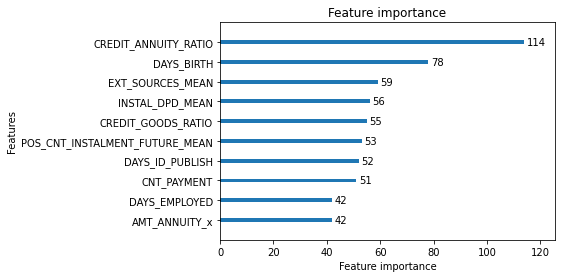

In [81]:
plot_importance(final_clf, max_num_features=10, grid=False)
plt.show()